# Exercise 7 Solution - Markov Chain & Variational Monte Carlo

In [1]:
import numpy as np
import numdifftools as nd
import random

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.rcParams['text.usetex'] = True

In [2]:
def common_plt(*, title, xlabel, ylabel, fontsize=14, xlim=None, ylim=None,
               xone=False, yone=False, legend=True, legend_loc=None):
    plt.gcf().set_size_inches(10, 7)
    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize, rotation='horizontal', ha='right')
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
    if xone:
        plt.axvline(1, color='grey', linestyle='--')
    if yone:
        plt.axhline(1, color='grey', linestyle='--')
    if legend:
        plt.legend(loc=legend_loc)
    plt.show()

## Monte Carlo Sampling

In [3]:
def rng(a=0, b=1):
    return random.uniform(a, b)

def autocorrelation(x) :
    """
    Compute the autocorrelation of the signal, based on the properties of the
    power spectral density of the signal.
    """
    xp = x - np.mean(x)
    f = np.fft.fft(xp)
    p = np.array([np.real(v)**2 + np.imag(v)**2 for v in f])
    pi = np.fft.ifft(p)
    return np.real(pi)[:x.size//2] / np.sum(xp**2)

def autocorrelation_exact(x):
    """
    Compute the autocorrelation of the signal using the exact formula.
    """
    avg_sq = np.mean(x)**2
    sq_avg = np.mean(x**2)
    avg_corr = [np.mean(x[j:] * x[:x.size - j]) for j in range(x.size // 2)]
    return (avg_corr - avg_sq) / (sq_avg - avg_sq)
    
def autocorrelation_time(autocorr):
    """
    Compute the autocorrelation time from the list of autocorrelations rho[j].
    """
    return 0.5 + 2. * np.sum(autocorr[:np.argmax(ac < 0)])

A simple Markov Chain Monte Carlo sampler.

In [4]:
def sampler(dist, n, delta):
    """
    Perform Markov Chain Monte Carlo sampling from a distribution 'dist'.
    """

    def proposal(x, delta):
        return x + delta * (rng() - 0.5)

    def acceptance(x, x2):
        return min(1, dist(x2) / dist(x))  # fulfills detailed balance

    hits = 0
    x = 0
    xs = np.zeros(n)

    for i in range(n):
        x2 = proposal(x, delta)
        if acceptance(x, x2) > rng():
            x = x2
            hits += 1
        xs[i] = x
    return np.array(xs), float(hits) / n


Check that we sample from the Gaussian distribution by checking the histogram:

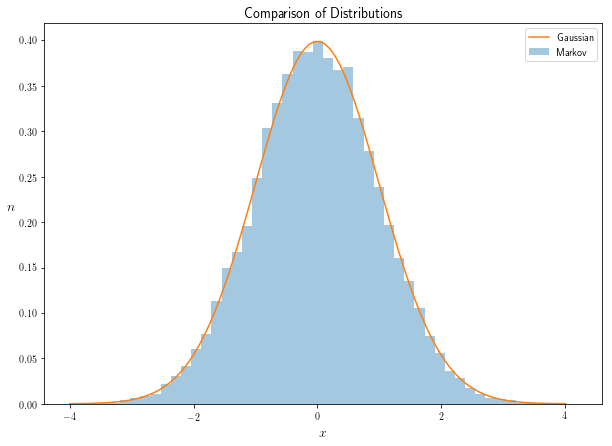

In [5]:
N = 50000
dist = lambda x: np.exp(- 0.5 * x**2) # normal distribution
xs, accrate = sampler(dist, N, delta=5)

plt.hist(xs, 50, density=True, label='Markov', alpha = 0.4)
x = np.linspace(-4, 4, 100)
y = np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
plt.plot(x, y, label='Gaussian')
#plt.hist(np.random.randn(N), 50, density=True, label='Gaussian', alpha = 0.4)
common_plt(title='Comparison of Distributions',
           xlabel='$x$', ylabel='$n$')

We calculate $\langle x^2\rangle$ by sampling over the distribution, and plot the autocorrelation for different step sizes.

Delta = 0.1
acceptance rate: 0.98604
sigma = 0.6061446824447221
<x^2> = 0.38378605577626 +/- 0.06059198742756292
Tau = 499.6291867487289

Delta = 0.5
acceptance rate: 0.9301
sigma = 0.7364575920565237
<x^2> = 0.5425076173950127 +/- 0.018674808126932414
Tau = 32.150432075002584

Delta = 1
acceptance rate: 0.85896
sigma = 0.7164451178166837
<x^2> = 0.5134029296563919 +/- 0.009920616403513764
Tau = 9.586972106560847

Delta = 5
acceptance rate: 0.43556
sigma = 0.7074019681840167
<x^2> = 0.5004507818442784 +/- 0.0055353345812287095
Tau = 3.06143632026453

Delta = 20
acceptance rate: 0.11364
sigma = 0.7068998661710001
<x^2> = 0.49970814131088415 +/- 0.009441980743387018
Tau = 8.920319836064303

Delta = 100
acceptance rate: 0.02282
sigma = 0.7436126282691105
<x^2> = 0.5531804208802662 +/- 0.023701671915394174
Tau = 50.79657794336103



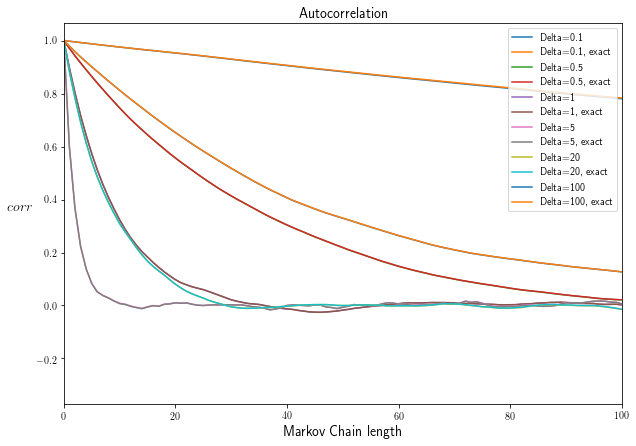

In [11]:
N = 50000
dist = lambda x: np.exp(-x**2)

for delta in [0.1, 0.5, 1, 5, 20, 100]:

    xs, accrate = sampler(dist, N, delta)

    ac = autocorrelation(xs**2)
    ac_exact = autocorrelation_exact(xs**2)

    tau = autocorrelation_time(ac)
    sigma = np.std(xs)
    error = sigma / np.sqrt(N / tau)
    print('Delta =', delta)
    print('acceptance rate:', accrate)
    print('sigma =', sigma)
    print('<x^2> = {} +/- {}'.format(np.mean(xs**2), error))
    print('Tau = {}\n'.format(tau))
    plt.plot(ac, label='Delta={}'.format(delta))
    plt.plot(ac_exact, label='Delta={}, exact'.format(delta))

plt.xlim(0,100)
common_plt(title='Autocorrelation',
           xlabel='Markov Chain length', ylabel='$corr$')


## Stochastic Optimization

In [7]:
class Sampler:
    def __init__(self, psi=np.cos):
        self.set_psi(psi)
        self.x = 0
        self.accept = 0
        self.moves = 0

    def set_psi(self, psi):
        self.psi = psi
        # We use automatic differantiation to compute the second derivative of the wave function,
        # needed to compute the kinetic-energy part of the hamiltonian
        self.d2psi = nd.Derivative(self.psi, n=2)

    # Markov-Chain transitions
    # the particle is displaced by a uniform random quantity
    # in 0.5[-step_size,step_size]
    def propose(self, step_size):
        return self.x + (np.random.uniform() - 0.5) * step_size  # GENERIC

    # acceptance test
    def step(self, step_size):
        xprime = self.propose(step_size)
        if((self.psi(xprime) / self.psi(self.x))**2. > np.random.uniform()):  # GENERIC
            self.x = xprime
            self.accept += 1
        self.moves += 1

    def acceptance(self):
        return self.accept / float(self.moves)

    # Local energy (see script)
    def local_energy(self, pot):
        return -0.5 * self.d2psi(self.x) / self.psi(self.x) + pot(self.x)

### Harmonic Oscillator

In [8]:
class State:
    def __init__(self, alpha):
        self.param = alpha

    def __call__(self,x):
        return np.exp(self._alpha * x**2.)
    
    @property
    def param(self):
        return self._alpha
    
    @param.setter
    def param(self, alpha):
        self._alpha = alpha

    def a_derivative(self,x):
        return x**2.

def harmonic(x):
    return 0.5 * x**2.

In [9]:
N = 100
DELTA = 3
for p in [0.2, 0.4, 0.5, 0.6, 1]:
    psi = State(-p)
    sampler = Sampler(psi)
    elocs = []
    for _ in range(N):
        sampler.step(step_size=DELTA)
        elocs.append(sampler.local_energy(pot=harmonic))
    print('p = {:<3}, Eloc = {:.6f}, sigma = {:.6g}'.format(p, np.mean(elocs), np.std(elocs)))
    

p = 0.2, Eloc = 0.733717, sigma = 0.679454
p = 0.4, Eloc = 0.490107, sigma = 0.125527
p = 0.5, Eloc = 0.500000, sigma = 2.24616e-12
p = 0.6, Eloc = 0.544367, sigma = 0.0889807
p = 1  , Eloc = 0.619698, sigma = 0.368624


In [10]:
psi = State(-2)
vmc = Sampler()
N = 100
delta = 3
learning_rate = 0.1

energies=[]
temperatures = []
tol = 1e-5
energy = 0; old_energy = energy + 2*tol

while abs(energy-old_energy) > tol:
    vmc.set_psi(psi)

    elocs = np.zeros(N)
    psi_der = np.zeros(N)

    gradients = []
    for n in range(N):
        vmc.step(delta)
 
        elocs[n] = (vmc.local_energy(harmonic))
        psi_der[n] = (psi.a_derivative(vmc.x))

    grad_k = 2 * (elocs - np.mean(elocs)) * psi_der
    grad_k_mean = np.mean(grad_k)

    psi.param = psi.param - learning_rate * grad_k_mean

    old_energy = energy
    energy = np.mean(elocs)

    
    energies.append(energy)
    temperatures.append(learning_rate * np.var(grad_k) / 2.)
    
    print("alpha  = {}".format(psi.param))
    print("energy = {}, sigma = {}, dE = {}\n".format(energy, np.std(elocs), energy - old_energy))

alpha  = -1.9902920354709779
energy = 1.533853813215302, sigma = 0.6033644585471245, dE = 1.533853813215302

alpha  = -1.9559868527103539
energy = 0.9477547017826575, sigma = 1.128341856178135, dE = -0.5860991114326444

alpha  = -1.8860594430412603
energy = 1.099110930834119, sigma = 1.5813043512049985, dE = 0.1513562290514614

alpha  = -1.8613285065564742
energy = 1.1353441634837689, sigma = 0.9043818511487999, dE = 0.03623323264964995

alpha  = -1.8471431952593604
energy = 1.2174663030553814, sigma = 0.6752725717314614, dE = 0.08212213957161252

alpha  = -1.7586264296169682
energy = 0.7084369503896721, sigma = 1.6729749654045223, dE = -0.5090293526657093

alpha  = -1.7357399920359278
energy = 0.8845301794204787, sigma = 0.8066027996965882, dE = 0.1760932290308066

alpha  = -1.6892753849375024
energy = 1.0950031635572153, sigma = 1.1330141486584135, dE = 0.21047298413673654

alpha  = -1.656899313679112
energy = 0.5196472303707341, sigma = 0.9181285360310869, dE = -0.5753559331864811



alpha  = -0.5000243302069793
energy = 0.49999715860236044, sigma = 4.7706230581158015e-05, dE = 2.6785819598362792e-05

alpha  = -0.5000217612340786
energy = 0.5000043998423455, sigma = 2.5001032463299196e-05, dE = 7.241239985023018e-06



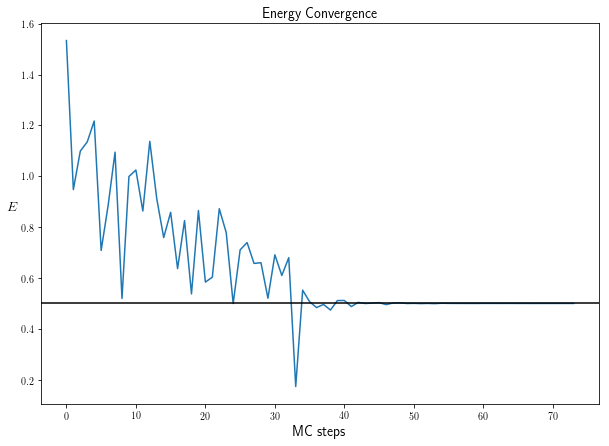

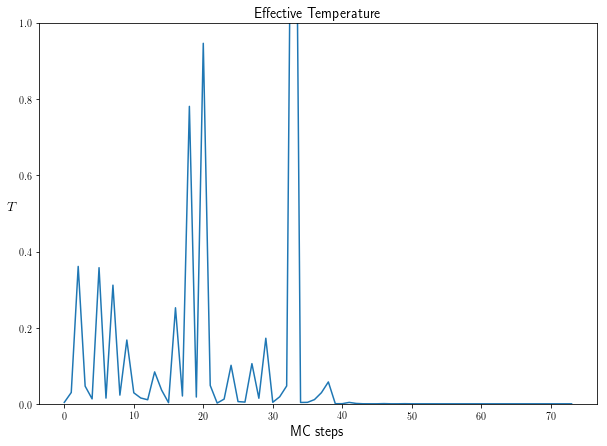

In [11]:
plt.plot(energies)
plt.axhline(0.5,color='black')
common_plt(title='Energy Convergence', xlabel='MC steps', ylabel='$E$', legend=False)

plt.plot(temperatures)
common_plt(title='Effective Temperature', xlabel='MC steps', ylabel='$T$', legend=False, ylim=(0, 1))

Here we see the sensitive dependence on tuning parameters: even though our energy attains an approximate value for the exact solution, the convergence speed can come at the cost of beating around the bush for a while. Also note the zero-variance property.

### Anharmonic Oscillator

In [12]:
#We take a wave-function
#exp(-a^2 x^2 - b^2 x^4 ...)
#the coefficients a^2,b^2 are squared in order to guarantuee that the wave-function does not diverge
#at +/- infinity
class State:
    def __init__(self, alpha):
        self.param = alpha
        self.npar = len(alpha)

    def __call__(self, x):
        logpsi = 0
        for i in range(self.npar):
            logpsi -= self._alpha[i]**2. * x**(2*(i+1.))
        return np.exp(logpsi)

    @property
    def param(self):
        return self._alpha

    @param.setter
    def param(self, alpha):
        self._alpha = np.copy(alpha)

    def a_derivative(self,x):
        ders = []
        for i in range(self.npar):
            ders.append(-x**(2 * (i + 1.)) * self._alpha[i] * 2)
        return ders

ANH_STRENGTH = 0.2

def anharmonic(x):
    return 0.5 * x**2. + ANH_STRENGTH * x**4.


In [13]:
psi = State([0.5])
vmc = Sampler()

N = 500
delta = 4
learning_rate = 0.075

npar = psi.npar
energies = []

tol = 3*1e-4
energy = 0; old_energy = energy+2*tol

while abs(energy-old_energy) > tol:
    vmc.set_psi(psi)

    elocs = np.zeros(N)
    psi_der = np.zeros((N,npar))

    for n in range(N):
        vmc.step(delta)

        elocs[n] = vmc.local_energy(anharmonic)
        psi_der[n] = psi.a_derivative(vmc.x)

    
    eloc_mean = np.mean(elocs)
    grad_k = 2 * (elocs - eloc_mean) * psi_der.T # shape (npar, N)
    grad_k_mean = np.mean(grad_k, axis=-1) # shape (npar,)

    psi.param = psi.param - learning_rate * grad_k_mean

    old_energy = energy
    energy = eloc_mean
    energies.append(eloc_mean)
    print("alpha  = {}".format(psi.param))
    print("energy = {}, sigma = {}, dE = {}\n".format(energy, np.std(elocs), energy - old_energy))

alpha  = [1.62848731]
energy = 1.3600595600531975, sigma = 5.240010525547809, dE = 1.3600595600531975

alpha  = [1.58507469]
energy = 1.508461775418456, sigma = 1.0955283407800016, dE = 0.14840221536525844

alpha  = [1.49335566]
energy = 1.4036647353570644, sigma = 1.523385616937699, dE = -0.10479704006139157

alpha  = [1.29032001]
energy = 0.8137821886168563, sigma = 2.047772617191716, dE = -0.5898825467402081

alpha  = [1.24346862]
energy = 0.988525144275972, sigma = 0.773546318926439, dE = 0.1747429556591158

alpha  = [1.17238558]
energy = 0.8961249062909156, sigma = 0.8858251417089763, dE = -0.09240023798505648

alpha  = [1.11411304]
energy = 0.8238604495097664, sigma = 0.7178349873515568, dE = -0.07226445678114912

alpha  = [1.03987531]
energy = 0.7415586771620671, sigma = 0.7218966730053833, dE = -0.08230177234769931

alpha  = [0.99452019]
energy = 0.712701791182924, sigma = 0.48525297112931026, dE = -0.028856885979143154

alpha  = [0.96039816]
energy = 0.6601038979202695, sigma 

Exact E = 0.602405, VMC E = 0.6047011833319592


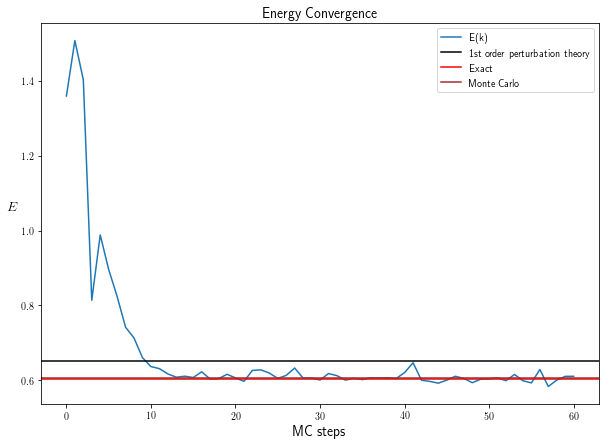

In [14]:
plt.plot(energies, label='E(k)')

vmc_energy = np.mean(energies[-int(len(energies)/3):])
exact_energy=0.602405

#compare this result with firt-order perturbation theory
#hint: compute <x^4> using samples from the exact wave-function
enpert = 0.5+0.75*ANH_STRENGTH

print('Exact E = {}, VMC E = {}'.format(exact_energy, vmc_energy))

plt.axhline(enpert, color='black', label='1st order perturbation theory')
plt.axhline(exact_energy, color='red', label='Exact')
plt.axhline(vmc_energy, color='brown', label='Monte Carlo')
common_plt(title='Energy Convergence',
           xlabel='MC steps', ylabel='$E$')

## Helium Atom

In [15]:
class vmc_twopart_sampler:
    def __init__(self, dim=3, psi=np.cos):
        self.dim = dim
        self.psi = psi
        self.x1 = np.random.rand(self.dim) - 0.5
        self.x2 = np.random.rand(self.dim) - 0.5
        self.accept = 0
        self.moves = 0

    # Markov-Chain transitions
    def propose(self, delta):
        return (self.x1 + delta * (np.random.rand(self.dim) - 0.5),
                self.x2 + delta * (np.random.rand(self.dim) - 0.5))

    # acceptance test
    def step(self,step_size):
        xp1, xp2 = self.propose(step_size)
        if (psi(xp1, xp2) / psi(self.x1, self.x2))**2 > np.random.uniform():
            self.x1 = xp1
            self.x2 = xp2
            self.accept += 1
        self.moves += 1

    def acceptance(self):
        return self.accept/float(self.moves)

    def local_energy(self):
        return psi.local_energy(self.x1, self.x2)

    def psi_derivative(self):
        return psi.a_derivative(self.x1, self.x2)


class Jastrow_state:
    def __init__(self,p):
        self.param = p

    def __call__(self, e1, e2):
        r1 = np.linalg.norm(e1)
        r2 = np.linalg.norm(e2)
        r12 = np.linalg.norm(e1-e2)
        return np.exp(-2*r1 - 2*r2 + r12 / (2 * (1 + self._p*r12)))

    @property
    def param(self):
        return self._p
    
    @param.setter
    def param(self, p):
        self._p = p

    def local_energy(self, e1, e2):
        r1 = np.linalg.norm(e1)
        r2 = np.linalg.norm(e2)
        r12 = np.linalg.norm(e1-e2)
        dotp = np.dot((e1 - e2) / r12, e1/r1 - e2/r2)
        den = 1 / (1 + self._p * r12)
        den2 = den**2
        return -4 + self._p * (den + den2 + den*den2) - den2**2/4 + dotp * den2

    # Derivative of psi with regards to a
    def a_derivative(self, e1, e2):
        r1 = np.sqrt(np.dot(e1, e1))
        r2 = np.sqrt(np.dot(e2, e2))
        r = np.sqrt(np.dot(e1-e2, e1-e2))
        dotp = np.dot((e1 - e2) / r, e1/r1 - e2/r2)
        a = self._p
        return -(2*dotp * r**3 * a**2 + (4*dotp * r**2 - 3*r)*a + (2*dotp - 1)*r - 3
                ) / (r*a + 1)**5

def optimise(sampler, psi, learn=0.1, n=10000, delta=1, maxiter=100):

    # Thermalization: aim for acceptance ratio ~0.5
    ntherm = int(0.3*n)
    learning_interval = int(0.1 * ntherm) + 1;
    for i in range(ntherm):
        sampler.step(delta)
        if (i+1) % learning_interval == 0:
            delta *= sampler.accept / (0.5 * learning_interval)
            sampler.accept = 0
    print("Adjusted delta = {}".format(delta))

    # Find good Pade-Jastrow parameter
    it = 0
    tol = 1e-4
    oldp = psi.param + 2 * tol
    energies = []
    while abs(psi.param - oldp) > tol:

        if it >= maxiter:
            print("Not converged after {} iterations, p = {}".
                  format(it, psi.param))
            return None, psi.param
        it += 1
        oldp = psi.param

        elocs = np.zeros(n)
        psi_der = np.zeros(n)

        for i in range(n):
            sampler.step(delta)
            elocs[i] = sampler.local_energy()
            psi_der[i] = sampler.psi_derivative()

        if(it % 5 == 0):
            # TODO: Add autocorrelation time to error estimate.
            print("Energy: {} +/- {} (p: {})".format(np.mean(elocs),
                                                     np.std(elocs)/np.sqrt(n),
                                                     psi.param))

        energy = np.mean(elocs)
        energies.append(energy)
        grad_k = 2 * (elocs - energy) * psi_der
        grad_k_mean = np.mean(grad_k)

        psi.param = psi.param - learning_rate * grad_k_mean
    
    return np.mean(energies), psi.param


In [16]:
n = 1000                    # VMC chain length
delta = 2                   # Initial step size
psi = Jastrow_state(p=2)    # State with initial Pade-Jastrow parameter
learning_rate = 1           # Optimisation rate of p

E, p = optimise(vmc_twopart_sampler(psi=psi), psi, n=n, learn=learning_rate)
print("E0 = {}, p = {}".format(E, p))

Adjusted delta = 0.49571596467395856
Energy: -3.0441200311662233 +/- 0.012579773184851657 (p: 1.1874053909097653)
Energy: -2.8543159845253276 +/- 0.010157402560964578 (p: 0.33689392815445496)
Energy: -2.894152891189449 +/- 0.007902119174567738 (p: 0.34547126677680506)
Energy: -2.6799978448611137 +/- 0.007866029546159193 (p: 0.41340686770979784)
Energy: -3.0382997090017554 +/- 0.011554600150471751 (p: 0.37222523215899816)
Energy: -2.9513067328503784 +/- 0.009545811814741243 (p: 0.2536441380412022)
Energy: -2.990651232720115 +/- 0.00972828843090305 (p: 0.4429863721541534)
Energy: -2.795764477921315 +/- 0.009957446895622703 (p: 0.5009690141348853)
Energy: -2.8789946646322337 +/- 0.009345325966505579 (p: 0.23284997656662315)
Energy: -2.761459124212158 +/- 0.008859107680399015 (p: 0.26222322009383525)
Energy: -2.8455077004802893 +/- 0.009661064025563298 (p: 0.1750804258346096)
Energy: -2.8493133601421503 +/- 0.010408265473353115 (p: 0.4283360122649338)
Energy: -3.002143642060909 +/- 0.00743

We start with some initial guess and high mobility. This will lead us near some minimum, but requires adapting the parameters for convergence. 

In [17]:
n = 30000                   # VMC chain length
delta = 0.4                 # Initial step size
psi = Jastrow_state(p=0.3)  # State with initial Pade-Jastrow parameter
learning_rate = 0.1         # Optimisation rate of p

E, p = optimise(vmc_twopart_sampler(psi=psi), psi, n=n, learn=learning_rate)
print("E0 = {}, p = {}".format(E, p))

Adjusted delta = 0.9609167762206239
Energy: -2.868579018915327 +/- 0.0016624088607914461 (p: 0.3171310180075884)
E0 = -2.8702484659071055, p = 0.324384783134833


A fine search yields good results (compare previous methods) within reasonable time. This proves the usefulness of even non-specialised MC algorithms.

## Common Implementations

ALPS (http://alps.comp-phys.org/): VMC for lattice quantum spin models, co-developed at ETH

QMC course (http://www.physics.buffalo.edu/phy411-506/topic5/): overview with simple samples at UB